## Prerequisits

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
# from scipy.sparse import csr_matrix

# import warnings
# warnings.filterwarnings('ignore')

### Rollcalls data

In [ ]:
members = pd.read_csv('irt_files/S109_members.csv')
votes = pd.read_csv('irt_files/S109_votes.csv')
rollcalls = pd.read_csv('irt_files/S109_rollcalls.csv')

print(f"Loaded {len(votes)} votes, {len(members)} members, {len(rollcalls)} roll calls")

In [ ]:
"""
Preprocess the data to create vote matrix and metadata

IRT CONNECTION: This creates the response matrix where:
- Rows = respondents (legislators, analogous to students in educational IRT)
- Columns = items (roll call votes, analogous to test questions in educational IRT)
- Values = binary responses (1=Yea/correct, 0=Nay/incorrect)
"""

# Filter for Senate only (chamber == 'Senate')
# votes_senate = votes[votes['chamber'] == 'Senate'].copy()
# members_senate = members[members['chamber'] == 'Senate'].copy()
# rollcalls_senate = rollcalls[rollcalls['chamber'] == 'Senate'].copy()
votes_senate = votes.copy()
members_senate = members.copy()
rollcalls_senate = rollcalls.copy()

# Create mapping dictionaries
member_to_idx = {icpsr: idx for idx, icpsr in enumerate(sorted(members_senate['icpsr'].unique()))}
rollcall_to_idx = {roll: idx for idx, roll in enumerate(sorted(rollcalls_senate['rollnumber'].unique()))}

# Create reverse mappings
idx_to_member = {idx: icpsr for icpsr, idx in member_to_idx.items()}
idx_to_rollcall = {idx: roll for roll, idx in rollcall_to_idx.items()}

n_members = len(member_to_idx)
n_rollcalls = len(rollcall_to_idx)

print(f"Matrix dimensions: {n_members} members x {n_rollcalls} roll calls")

# Initialize vote matrix with NaN (missing votes)
# IRT CONNECTION: This is the classic IRT response matrix R[person, item]
vote_matrix = np.full((n_members, n_rollcalls), np.nan)

# Fill in the vote matrix
# Cast codes: 1,2,3 = Yea, 4,5,6 = Nay, 7,8,9 = Not voting/Present
for _, row in votes_senate.iterrows():
    if row['icpsr'] in member_to_idx and row['rollnumber'] in rollcall_to_idx:
        member_idx = member_to_idx[row['icpsr']]
        roll_idx = rollcall_to_idx[row['rollnumber']]
        
        # Convert cast codes to binary votes
        # IRT CONNECTION: Converting to binary responses (0/1) like correct/incorrect in educational testing
        if row[f'cast_code'] in [1, 2, 3]:  # Yea votes
            vote_matrix[member_idx, roll_idx] = 1
        elif row[f'cast_code'] in [4, 5, 6]:  # Nay votes
            vote_matrix[member_idx, roll_idx] = 0
        

# print(vote_matrix)

# Create member info dataframe with proper ordering
member_info = []
for idx in range(n_members):
    icpsr = idx_to_member[idx]
    member_row = members_senate[members_senate['icpsr'] == icpsr].iloc[0]
    member_info.append({
        'idx': idx,
        'icpsr': icpsr,
        'bioname': member_row['bioname'],
        'state_abbrev': member_row['state_abbrev'],
        'party_code': member_row['party_code'],
        'nominate_dim_1': member_row['nominate_dim1'],
        'nominate_dim_2': member_row['nominate_dim2']
    })

member_info_df = pd.DataFrame(member_info)
# print(member_info_df)

# Convert party codes to letters (100=D, 200=R, others=I)
party_map = {100: 'D', 200: 'R', 328: 'I'}
member_info_df['party'] = member_info_df['party_code'].map(party_map).fillna('U')

# Remove roll calls with too few votes or unanimous votes
# IRT CONNECTION: Similar to removing items that are too easy/hard or have no discrimination
valid_rollcalls = []
valid_vote_matrix = []

for roll_idx in range(n_rollcalls):
    votes_col = vote_matrix[:, roll_idx]
    valid_votes = votes_col[~np.isnan(votes_col)]
    
    if len(valid_votes) >= 2:  # At least 10 votes
        yea_count = np.sum(valid_votes == 1)
        nay_count = np.sum(valid_votes == 0)
        
        # Skip unanimous votes (no discrimination power, like items everyone gets right/wrong)
        if yea_count > 0 and nay_count > 0:
            valid_rollcalls.append(roll_idx)
            valid_vote_matrix.append(votes_col)

vote_matrix_clean = np.column_stack(valid_vote_matrix)

print(f"After filtering: {vote_matrix_clean.shape[0]} members x {vote_matrix_clean.shape[1]} roll calls")

vote_matrix = vote_matrix_clean

pd.DataFrame(vote_matrix).to_csv("irt_files/rollcalls_vote_matrix.csv", index=False)

In [ ]:
member_info_df['members_abbv'] = member_info_df.apply(lambda row: f"{row['bioname'].split(', ')[0]} ({row['party']} {row['state_abbrev']})", axis=1)

R_manual_df = pd.read_csv("irt_files/ideal_points_R_manual_files.csv")
R_manual_df.columns =['members_abbv','ideal_dim_1', 'ideal_dim_2']
merged_df_2 = member_info_df.join(R_manual_df.set_index('members_abbv'), on='members_abbv', how='inner')
corr_dim1, p_value_dim1 = pearsonr(merged_df_2['nominate_dim_1'], merged_df_2['ideal_dim_1'])
corr_dim2, p_value_dim2 = pearsonr(merged_df_2['nominate_dim_2'], merged_df_2['ideal_dim_2'])
print("IDEAL-R Manual v DW Nominate Correlation:")
print("Dimension 1:")
print(f"Correlation: {corr_dim1:.6f}")
print(f"P-value: {p_value_dim1:.6f}")

print("Dimension 2:")
print(f"Correlation: {corr_dim2:.6f}")
print(f"P-value: {p_value_dim2:.6f}\n\n")

R_manual_df = pd.read_csv("irt_files/ideal_points_R_preloaded_files.csv")
R_manual_df.columns =['members_abbv','ideal_dim_1', 'ideal_dim_2']
merged_df_3 = member_info_df.join(R_manual_df.set_index('members_abbv'), on='members_abbv', how='inner')
corr_dim1, p_value_dim1 = pearsonr(merged_df_3['nominate_dim_1'], merged_df_3['ideal_dim_1'])
corr_dim2, p_value_dim2 = pearsonr(merged_df_3['nominate_dim_2'], merged_df_3['ideal_dim_2'])
print("IDEAL-R Builtin v DW Nominate Correlation:")
print("Dimension 1:")
print(f"Correlation: {corr_dim1:.6f}")
print(f"P-value: {p_value_dim1:.6f}")

print("Dimension 2:")
print(f"Correlation: {corr_dim2:.6f}")
print(f"P-value: {p_value_dim2:.6f}\n\n")

### LLM Response data

In [55]:
model_name = "llama-3.1-8b-it"
# model_name = "gemma-2-9b-it"

# Prompting
# votes = pd.read_csv(f"analysis/{model_name}_votes.csv")
# print(votes.isna().sum())
# response_cols = [col for col in votes.columns if col not in ['category', 'q_id']]
# votes = votes[response_cols].T

# Steering 
votes_1 = pd.read_csv(f"analysis/{model_name}_conservative_steering_131K_votes.csv")
print(votes_1.isna().sum())
votes_2 = pd.read_csv(f"analysis/{model_name}_liberal_steering_131K_votes.csv")
print(votes_2.isna().sum())
response_cols = [col for col in votes_1.columns if col not in ['category', 'q_id']]
votes_1 = votes_1[response_cols].rename(columns={col: f"-ve_{col[9:]}" for col in response_cols})
votes_2 = votes_2[response_cols].rename(columns={col: f"+ve_{col[9:]}" for col in response_cols})
votes = pd.concat([votes_1.T, votes_2.T])

vote_matrix = votes.values
member_info_df = pd.DataFrame({'idx': list(range(len(votes))),
                   'bioname': votes.index,
                   'party': ['U']*len(votes)})

q_id                                   0
steering_caa_argument_none            49
steering_sta_argument_none            18
steering_caa_argument_liberal          0
steering_sta_argument_liberal          0
steering_caa_argument_conservative     0
steering_sta_argument_conservative     0
category                               0
dtype: int64
q_id                                   0
steering_caa_argument_none            49
steering_sta_argument_none            18
steering_caa_argument_liberal          0
steering_sta_argument_liberal          0
steering_caa_argument_conservative     0
steering_sta_argument_conservative     0
category                               0
dtype: int64


## Check inputs

In [56]:
# most liberal: +ve_sta_argument_none:7
# most conservative:-ve_caa_argument_none:0


print(vote_matrix.shape)
member_info_df

(12, 126)


,idx,bioname,party
0,0,-ve_caa_argument_none,U
1,1,-ve_sta_argument_none,U
2,2,-ve_caa_argument_liberal,U
3,3,-ve_sta_argument_liberal,U
4,4,-ve_caa_argument_conservative,U
5,5,-ve_sta_argument_conservative,U
6,6,+ve_caa_argument_none,U
7,7,+ve_sta_argument_none,U
8,8,+ve_caa_argument_liberal,U
9,9,+ve_sta_argument_liberal,U


In [57]:
n_dims=2

n_members, n_rollcalls = vote_matrix.shape

# Create masks for observed votes
observed_mask = ~np.isnan(vote_matrix)

# Convert to binary format for observed votes only
vote_obs = vote_matrix[observed_mask].astype(int)

# Get indices for observed votes
member_idx, rollcall_idx = np.where(observed_mask)


# Assign each rollcall to a dimension (random assignment)
np.random.seed(42)  # for reproducibility
rollcall_to_dim = np.random.randint(0, n_dims, size=n_rollcalls)

# Create dimension index for each observation
dimension_idx = rollcall_to_dim[rollcall_idx]

print(f"Fitting {n_dims}D ideal point model...")
print("n_members:", n_members)
print("n_rollcalls:", n_rollcalls)
print("n_observations:", len(vote_obs))
print("Rollcalls per dimension:", np.bincount(rollcall_to_dim))

Fitting 2D ideal point model...
n_members: 12
n_rollcalls: 126
n_observations: 1378
Rollcalls per dimension: [53 73]


## IRT Using Stan
***

In [58]:
# Create Stan data dictionary
stan_data = {
    'J': n_members,
    'K': n_rollcalls, 
    'N': len(vote_obs),
    'D': n_dims,
    'jj': member_idx+1, # starting idx 1
    'kk': rollcall_idx+1, # starting idx 1
    'y': vote_obs,
    #-------------------------------- Fix extreme Legislators --------------------------------#
    # 'ref_j1': 3 + 1, # role_liberal_argument_liberal
    # 'ref_j2': 8 + 1, # role_conservative_argument_conservative
    # 'ref_j3': 7 + 1, # role_liberal_argument_conservative
    
    'ref_j1': 9 + 1, # +ve_sta_argument_liberal
    'ref_j2': 5 + 1, # -ve_sta_argument_conservative
    'ref_j3': 2 + 1, # -ve_sta_argument_liberal
    #-------------------------------- Fix extreme Legislators --------------------------------#
}

# import numpy as np

# # Choose 3 legislators to fix (you can pick based on domain knowledge)
# # For example, most liberal, most conservative, and someone in between
# fixed_legislators = [0, 1, 2]  # indices in your data (0-based)

# # Define their positions in 2D space
# # Common approach: place them at corners of a triangle
# fixed_positions = np.array([
#     [-1.0, -1.0],  # bottom-left
#     [ 1.0, -1.0],  # bottom-right  
#     [ 0.0,  1.0]   # top-center
# ])

# stan_data = {
#     'J': n_members,
#     'K': n_rollcalls, 
#     'N': len(vote_obs),
#     'D': n_dims,
#     'jj': member_idx+1,
#     'kk': rollcall_idx+1,
#     'y': vote_obs,
#     'n_fixed': 3,
#     'fixed_legs': [x+1 for x in fixed_legislators],  # convert to 1-based indexing
#     'fixed_pos': fixed_positions
# }
stan_data

{'J': 12,
 'K': 126,
 'N': 1378,
 'D': 2,
 'jj': array([ 1,  1,  1, ..., 12, 12, 12]),
 'kk': array([  5,   6,   8, ..., 124, 125, 126]),
 'y': array([1, 0, 0, ..., 0, 1, 0]),
 'ref_j1': 10,
 'ref_j2': 6,
 'ref_j3': 3}

In [59]:
import arviz as az
from cmdstanpy import CmdStanModel

stan_file = os.path.join('irt_files/MIRT_ref.stan')
model = CmdStanModel(stan_file=stan_file)
# print(model)
# print(json.dumps(model.exe_info(), indent=4))

In [60]:
n_samples=500
n_tune=500

fit = model.sample(
    data=stan_data, chains=4, 
    iter_sampling=n_samples, 
    iter_warmup=n_tune,
    # show_console=True
)

03:16:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:16:45 - cmdstanpy - INFO - CmdStan done processing.
03:16:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in 'MIRT_ref.stan', line 64, column 2 to column 29)
Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in 'MIRT_ref.stan', line 64, column 2 to column 29)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'MIRT_ref.stan', line 80, column 4 to column 81)
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'MIRT_ref.stan', line 80, column 4 to column 81)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'MIRT_ref.stan', line 80, column 4 to column 81)
	Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in 'MIRT_ref.stan', li

In [61]:
inference_data = az.from_cmdstanpy(fit)
inference_data
inference_data.to_netcdf(f"analysis/inference_data{model_name}_steering.nc")

'analysis/inference_datallama-3.1-8b-it_steering.nc'

### Diagnosis

In [ ]:
print(fit.diagnose())

In [ ]:
# import matplotlib.cm as cm

# n_chains = len(inference_data.posterior.chain)
# n_vars = len(inference_data.posterior.data_vars)
# print(f"Number of parameter variables: {n_vars}")

# # cmap = cm.get_cmap('ocean')  # or 'plasma', 'tab10', etc.
# # colors = [cmap(i / (n_chains - 1)) for i in range(n_chains)]

# az.plot_trace(inference_data, figsize=(20, 2*n_vars), legend=False) #chain_prop={'color': colors},
# plt.tight_layout()
# plt.show()

### IDEAL Points

In [62]:
"""
Extract mean ideal points from trace

IRT CONNECTION: These are the estimated person parameters (abilities/traits)
In educational IRT: student ability estimates
In political IRT: legislator ideological position estimates
"""
# inference_data = az.from_netcdf(f"analysis/inference_data{model_name}_steering.nc")

ideal_points_samples = inference_data.posterior['theta'].values
# Average across chains and samples to get point estimates
ideal_points = np.mean(ideal_points_samples, axis=(0, 1))

# Print some diagnostics
print(f"\nIdeal points shape: {ideal_points.shape}")
print("Ideal_points_sample:")
print(ideal_points[:5])
print(f"Dimension 1 range: [{ideal_points[:, 0].min():.3f}, {ideal_points[:, 0].max():.3f}]")
print(f"Dimension 2 range: [{ideal_points[:, 1].min():.3f}, {ideal_points[:, 1].max():.3f}]")



Ideal points shape: (12, 2)
Ideal_points_sample:
[[-2.17338944  0.22371291]
 [-3.92304415 -0.66707317]
 [ 0.          2.        ]
 [-1.84875827  0.97054672]
 [ 3.4679767   1.581983  ]]
Dimension 1 range: [-3.923, 3.478]
Dimension 2 range: [-3.533, 2.000]


### Check Correlations

In [ ]:

merged_df_1 = member_info_df.join(pd.DataFrame(ideal_points, columns=['ideal_dim_1', 'ideal_dim_2']))
# print(merged_df)
# Calculate correlations
corr_dim1, p_value_dim1 = pearsonr(merged_df_1['nominate_dim_1'], merged_df_1['ideal_dim_1'])
corr_dim2, p_value_dim2 = pearsonr(merged_df_1['nominate_dim_2'], merged_df_1['ideal_dim_2'])

print("IRT-Stan v DW Nominate Correlation:")
print("Dimension 1:")
print(f"Correlation: {corr_dim1:.6f}")
print(f"P-value: {p_value_dim1:.6f}")

print("Dimension 2:")
print(f"Correlation: {corr_dim2:.6f}")
print(f"P-value: {p_value_dim2:.6f}\n\n")



### Plot IDEAL Points

In [63]:
cm_mapping = {
    '-ve_caa_argument_none':        ('o', 'red'), 
    '-ve_sta_argument_none':        ('^', 'red'),
    '-ve_caa_argument_liberal':     ('s', 'red'), 
    '-ve_sta_argument_liberal':     ('p', 'red'),
    '-ve_caa_argument_conservative':('P', 'red'), 
    '-ve_sta_argument_conservative':('*', 'red'),
    
    '+ve_caa_argument_none'         :('o', 'blue'), 
    '+ve_sta_argument_none'         :('^', 'blue'),
    '+ve_caa_argument_liberal'      :('s', 'blue'), 
    '+ve_sta_argument_liberal'      :('p', 'blue'),
    '+ve_caa_argument_conservative' :('P', 'blue'), 
    '+ve_sta_argument_conservative ':('*', 'blue')
}

# cm_mapping = {
#     'role_original_argument_none':              ('o', 'green'), 
#     'role_original_argument_liberal':           ('^', 'green'),
#     'role_original_argument_conservative':      ('s', 'green'), 
    
#     'role_liberal_argument_none':               ('o', 'blue'),
#     'role_liberal_argument_liberal':            ('^', 'blue'), 
#     'role_liberal_argument_conservative':       ('s', 'blue'),
    
#     'role_conservative_argument_none':          ('o', 'red'), 
#     'role_conservative_argument_liberal':       ('^', 'red'),
#     'role_conservative_argument_conservative':  ('s', 'red'), 

# }

Creating plot...


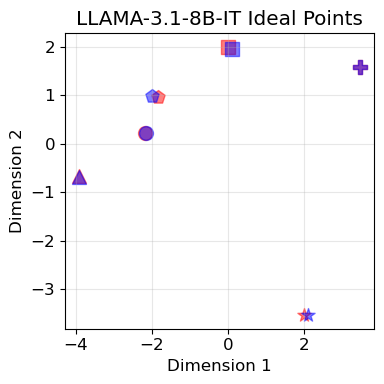

In [65]:
"""
Create the ideal points plot matching R output

IRT CONNECTION: This visualizes the estimated person parameters (θ) in 2D space
Each point represents a legislator's estimated ideological position
"""
print("Creating plot...")
plt.clf()
# Set up colors
party_colors = {'D': 'blue', 'R': 'red', 'I': 'green', 'U': 'purple'}
colors = [party_colors[party] for party in member_info_df['party']]

# Create plot
# plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 12, 'figure.figsize': (4,4)})

for i, (k, v) in enumerate(cm_mapping.items()):
    plt.scatter(ideal_points[i, 0], ideal_points[i, 1], 
                c=v[1], marker=v[0], s=100, alpha=0.5)

# Scatter plot of ideal points (IRT person parameters)
# plt.scatter(ideal_points[:, 0], ideal_points[:, 1], 
#             c=colors, s=50, alpha=0.7)

# Add labels for each point
# for i, row in member_info_df.iterrows():
#     # Format name like R output: "LASTNAME (PARTY STATE)"
#     name_parts = row['bioname'].split(', ')
#     if len(name_parts) >= 2:
#         lastname = name_parts[0]
#     else:
#         lastname = row['bioname']
    
#     # label = f"{lastname} ({row['party']} {row['state_abbrev']})"
#     # label = f"{lastname} ({row['party']})"
#     label = row['bioname']
    
#     plt.annotate(label, 
#                 (ideal_points[i, 0], ideal_points[i, 1]),
#                 xytext=(5, 5), textcoords='offset points',
#                 fontsize=12, alpha=0.8, rotation=-5, 
#                 ha='left', va='center', rotation_mode='anchor')

# Formatting
plt.xlabel('Dimension 1')  # First IRT dimension (usually liberal-conservative)
plt.ylabel('Dimension 2')  # Second IRT dimension
plt.title(f'{model_name.upper()} Ideal Points')

# Legend
# legend_elements = [
#     plt.scatter([], [], c='blue', s=50, label='Democrat'),
#     plt.scatter([], [], c='red', s=50, label='Republican'),
#     plt.scatter([], [], c='green', s=50, label='Independent'),
#     # plt.scatter([], [], c='purple', s=100, label='LLM')
# ]
legend_elements = [plt.scatter([], [], marker=v[0], c=v[1], label=k) for k, v in cm_mapping.items()]
if "gemma" in model_name:
    plt.legend(handles=legend_elements,
            bbox_to_anchor=(1.05, 1), 
            loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
# print(f"Saving figure at ideal_points_llms_round_{round}.png")
plt.savefig(f"ideal_points_steering_{model_name}.pdf")
plt.show()


### Summary

In [ ]:
print("\nSummary by party:")
for party in ['D', 'R', 'I', 'U']:
    party_mask = member_info_df['party'] == party
    if party_mask.any():
        party_points = ideal_points[party_mask]
        print(f"{party}: n={np.sum(party_mask)}, "
                f"Dim1 mean={np.mean(party_points[:, 0]):.3f}, "
                f"Dim2 mean={np.mean(party_points[:, 1]):.3f}")

print("\nIRT-based ideal point analysis complete!")